# Generate a dictionnary of Dictionnary

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/29
- update : 2024/02/25


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+34187316c4 	current w_2024_07 setup


In [3]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize


from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
#%matplotlib widget
%matplotlib inline

# default plot style is accessible
plt.style.use('tableau-colorblind10')

from collections import OrderedDict

In [4]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [5]:
list(butler.registry.queryDimensionRecords('detector', where="instrument='LATISS' AND detector.id IN (0..8)"))

[detector.RecordClass(instrument='LATISS', id=0, full_name='RXX_S00', name_in_raft='RXX_S00', raft=None, purpose='SCIENCE')]

### access to skymap

https://github.com/sylvielsstfr/MyDP0LSS/blob/main/myDP0.2/TrackAndPatch/PlotTractAndPatchs_butler.ipynb

In [6]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [7]:
datasetRefs = butler.registry.queryDatasets(datasetType='skyMap', collections=my_collection, where= "instrument='LATISS'")

In [8]:
for i, ref in enumerate(datasetRefs):
    pprint(ref)
    skymap_id = ref.dataId["skymap"]
    if skymap_id ==  'latiss_v1':
        skymap = ref

DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'hsc_rings_v1'}, run='skymaps', id=6e7fc928-0dc3-4e1b-ae63-5fb63be46216)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'latiss_v1'}, run='skymaps', id=f677ff86-2b1c-4094-9dad-e39395052cd1)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'lsst_cells_v1'}, run='skymaps', id=857e0e80-8d08-44f4-a81b-84227b064d5b)


In [9]:
skymap = butler.get(ref)

In [10]:
my_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [11]:
#from lsst.daf.butler import Butler
#butler = Butler('SMALL_HSC')
skymap = butler.get('skyMap', skymap='latiss_v1', collections=my_collection)
tractInfo = skymap.generateTract(5616)
patch = tractInfo[41]
patch.getIndex()

Index2D(x=3, y=2)

In [12]:
#for patch in tractInfo:
#    print(patch.getSequentialIndex())

In [13]:
out_dict = {}

In [14]:
# Load data (deserialize)
import pickle
with open('../data/202402/Latiss_tractspatchs_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [15]:
tracts_patchs_dict

{10644: array([189, 183, 184, 164, 185, 203, 201, 207, 182, 162, 166, 165, 181,
        161, 188, 208, 180, 202]),
 5634: array([ 90, 110,  71, 112,  73, 109,  93,  92,  91,  53,  72,  55,  52,
        111,  54,  74]),
 3863: array([223, 261, 241, 242, 262, 260, 243, 222, 224]),
 452: array([41, 62, 22, 25, 23, 44, 42, 63, 43, 24]),
 5614: array([250, 251, 230, 210, 212, 232, 211, 213, 249, 229, 231]),
 5616: array([355, 358, 316, 338, 356, 336, 357, 337, 317, 335, 315, 334]),
 5615: array([274, 331, 312, 332, 294, 295, 293, 313, 333, 314, 275, 276]),
 5839: array([9, 8, 7]),
 10643: array([190, 171]),
 455: array([51, 52, 15, 33, 14, 53, 34, 13, 32]),
 382: array([343, 344, 342]),
 3864: array([274, 238, 217, 218, 273, 255, 235, 275, 237, 257, 219, 236, 256,
        254, 276, 216]),
 383: array([359, 360])}

In [16]:
list_of_tracts = list(tracts_patchs_dict.keys())
list_of_tracts

[10644, 5634, 3863, 452, 5614, 5616, 5615, 5839, 10643, 455, 382, 3864, 383]

In [17]:
npatches = 0
for itract in list_of_tracts:
    npatches += len(tracts_patchs_dict[itract])
print(npatches)    

123


In [18]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

numTracts=0
# collection of polygons
patches = [] # container of all polygons


tract_polygon_dict = {}
tract_ra_dict = {}
tract_dec_dict = {}

# the container of all Tract
Tract_Dict = OrderedDict()


# loop on tracts
#---------------
for tractInfo in skymap:
    tractID = tractInfo.getId()
    if tractID not in list_of_tracts:
        continue
    numTracts+=1  

    # container for each tract
    container_polygons_fortract = []
    container_ra_fortract = []
    container_dec_fortract = []

    Patch_Dict = OrderedDict()

    # loop on patch
    #--------------
  
    for patch in tractInfo:
       
        patchID = patch.getSequentialIndex()
        if patchID not in tracts_patchs_dict[tractID]:
            continue
        ibb=patch.getInnerBBox()
        tWCS=tractInfo.getWcs()
        corners = []
        # loop on the 4 corners
        for icorn,corner in enumerate(ibb.getCorners()):
            p = geom.Point2D(corner.getX(), corner.getY())
            coord = tWCS.pixelToSky(p)

            # the corners
            corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
            container_ra_fortract.append(coord.getRa().asDegrees()) 
            container_dec_fortract.append(coord.getDec().asDegrees()) 
               
        ## all corners of the patch
        corners_array = np.array(corners)
        corners_array = np.append(corners_array,[corners_array[0]],axis=0)

        # the dict contains all the corners in Ra,Dec
        Patch_Dict[patchID] =  corners_array
        
        polygon = Polygon(corners_array,closed=True)
        patches.append(polygon)
        container_polygons_fortract.append(polygon)
        
        
    tract_polygon_dict[tractID] = container_polygons_fortract
    tract_ra_dict[tractID] = np.array(container_ra_fortract)
    tract_dec_dict[tractID] = np.array(container_dec_fortract)
    
    Tract_Dict[tractID] = Patch_Dict
        
print(numTracts)   



13


In [19]:
Tract_Dict

OrderedDict([(382,
              OrderedDict([(342, array([[ 12.69437584, -72.91024487],
                                   [ 12.4111962 , -72.91379092],
                                   [ 12.39980658, -72.83057359],
                                   [ 12.6816523 , -72.82704592],
                                   [ 12.69437584, -72.91024487]])),
                           (343,
                            array([[ 12.41110175, -72.91379204],
                                   [ 12.12780416, -72.91694484],
                                   [ 12.11775058, -72.83371115],
                                   [ 12.39971258, -72.8305747 ],
                                   [ 12.41110175, -72.91379204]])),
                           (344,
                            array([[ 12.12770968, -72.91694583],
                                   [ 11.84430792, -72.91970512],
                                   [ 11.83559184, -72.83645711],
                                   [ 12.11765654, -72.83371

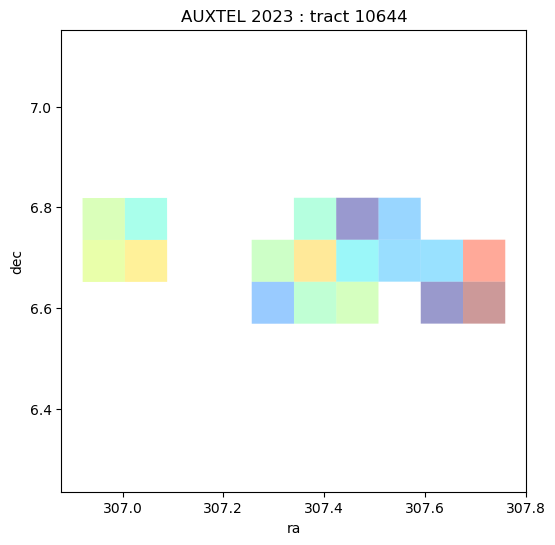

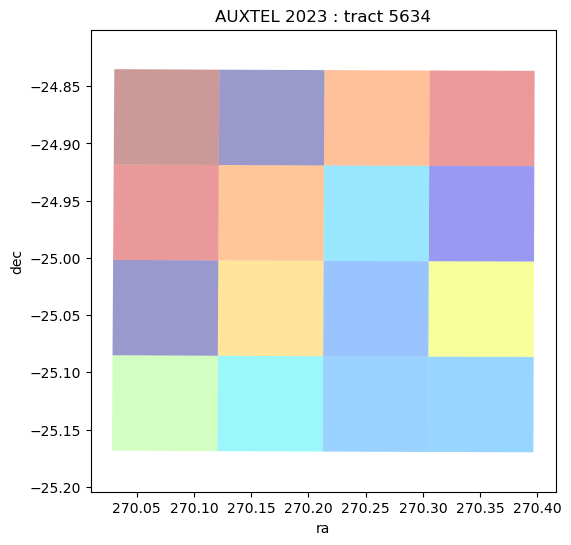

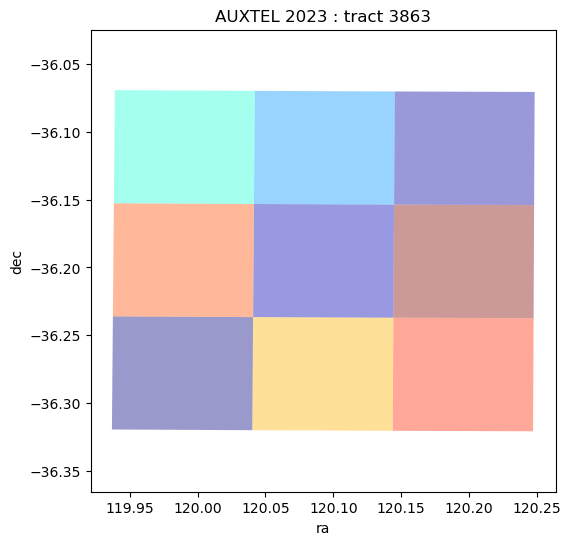

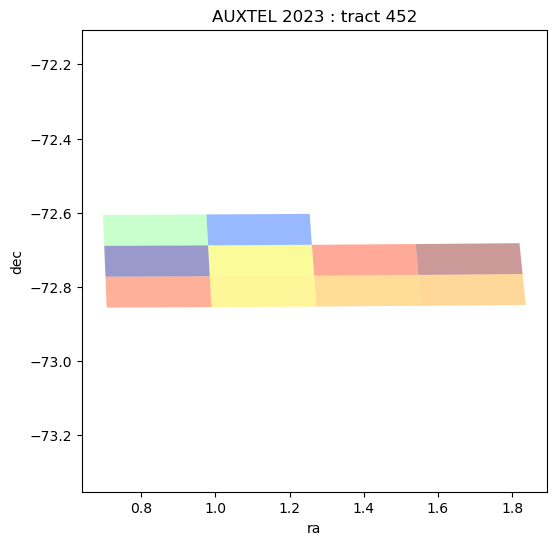

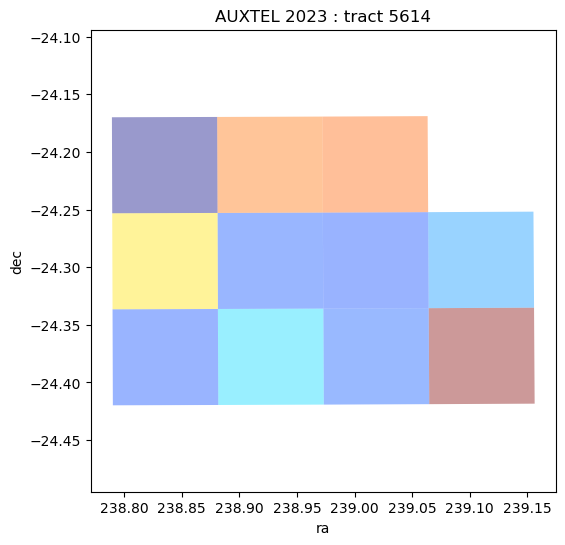

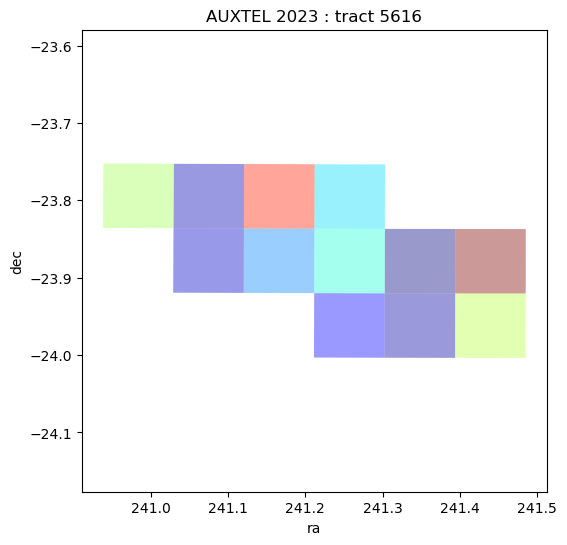

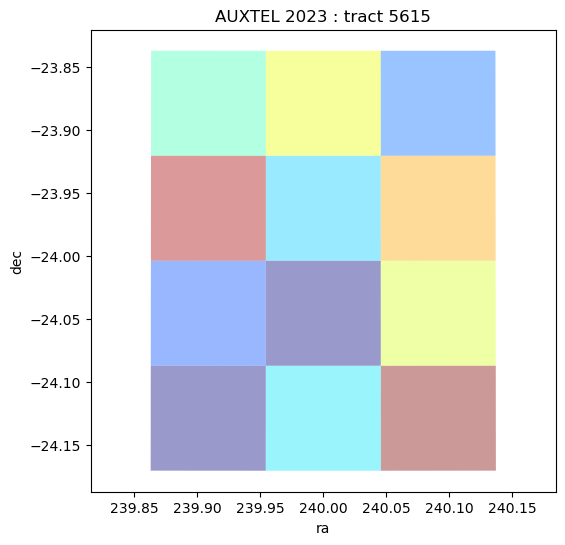

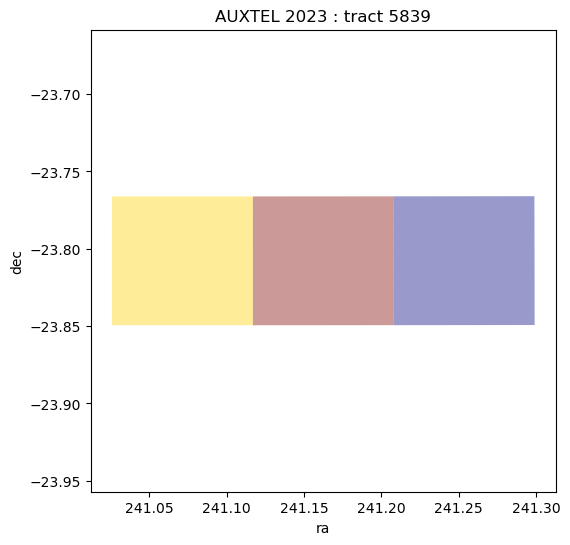

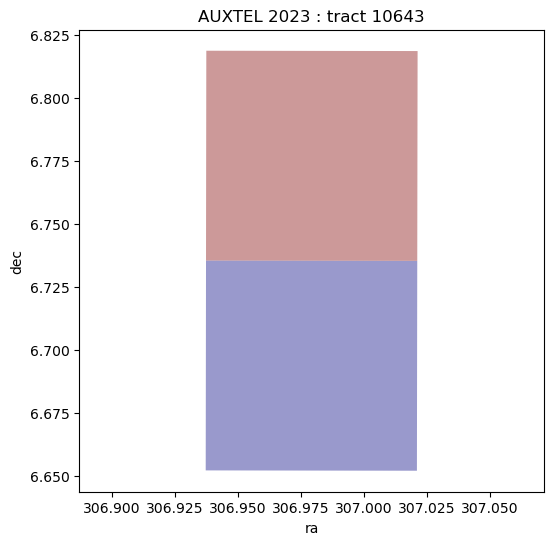

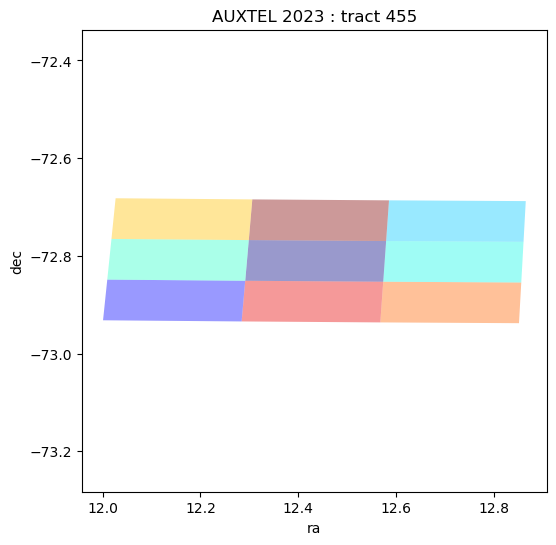

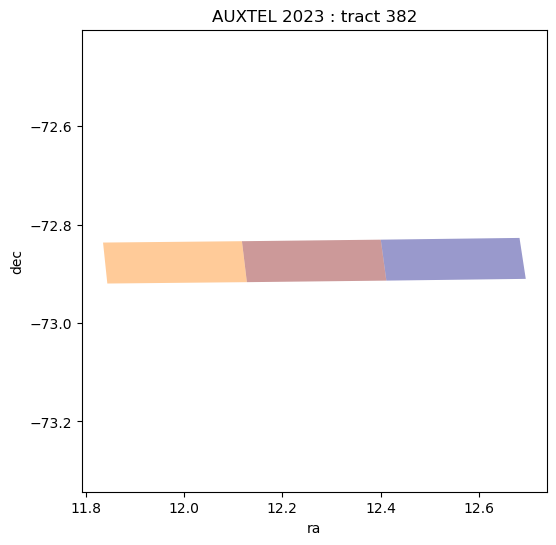

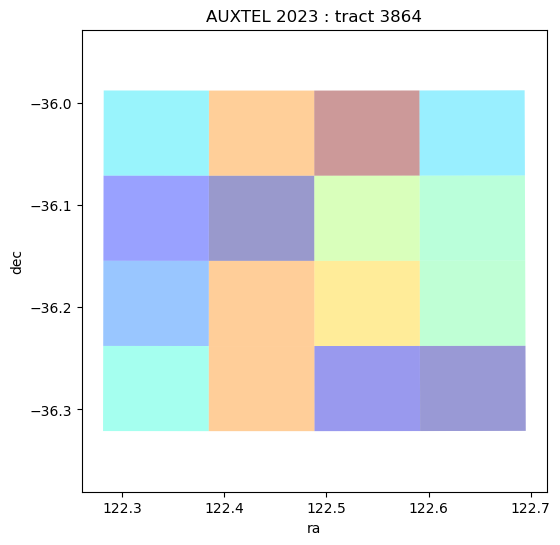

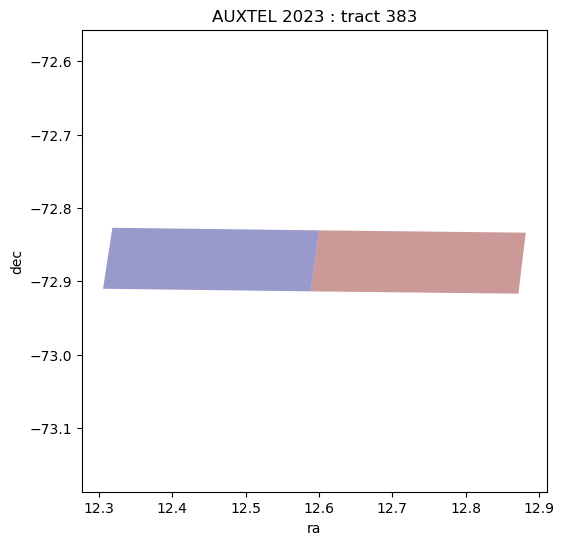

In [20]:
for itract in list_of_tracts:
    patches = tract_polygon_dict[itract]
    ra = tract_ra_dict[itract]
    dec = tract_dec_dict[itract]
    Xmin = ra.min()
    Xmax = ra.max()
    Ymin = dec.min()
    Ymax = dec.max()
    

    fig, ax = plt.subplots(figsize=(6,6))
    p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)

    colors = 50*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)  


    ax.set_xlim([Xmin,Xmax])
    ax.set_ylim([Ymin, Ymax])

    title = f"AUXTEL 2023 : tract {itract}"
    ax.set_title(title)
    ax.set_xlabel("ra")
    ax.set_ylabel("dec")
    #plt.gca().set_aspect('equal')
    ax.axis('equal')
    plt.show()

In [21]:
#
#fig=plt.figure()
#ax = fig.add_subplot(projection=wcs)
#ax.imshow(hdu[0].data, origin='lower')
#ax.grid(color='white', ls='solid')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
#ax.scatter(coord.ra.deg, coord.dec.deg, s=300, edgecolor='white', facecolor='none',transform=ax.get_transform('icrs'))
#ax.set_title(target_name_ned)

In [22]:
# coordinate : https://pipelines.lsst.io/py-api/lsst.geom.SpherePoint.html#lsst.geom.SpherePoint
tractInfo.contains?

Signature: tractInfo.contains(coord)
Docstring: Does this tract contain the coordinate?
File:      /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/skymap/ga8c6da7877+ef8d675bea/python/lsst/skymap/tractInfo.py
Type:      method